# Using A DNN To Discriminate Signal & Background Events in SUSY Dataset

Here, using the Keras module, we deploy a DNN and try to distinguish signal & background events in SUSY dataset, located at https://archive.ics.uci.edu/ml/machine-learning-databases/00279/.

In [1]:
# Importing the SUSY Data set
import sys, os
import pandas as pd

import numpy as np
import warnings
#Commnet the next line on to turn off warnings
#warnings.filterwarnings('ignore')


seed=12
np.random.seed(seed)
import tensorflow as tf
# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.set_random_seed(seed)

# Download the SUSY.csv (about 2GB) from UCI ML archive and save it in the same directory as this jupyter notebook
# See: https://archive.ics.uci.edu/ml/machine-learning-databases/00279/
filename="datasets/SUSY.csv"
#filename=os.path.expanduser('~')+'/ML_review/SUSY_data/SUSY.csv' 

columns=["signal", "lepton 1 pT", "lepton 1 eta", "lepton 1 phi", "lepton 2 pT", "lepton 2 eta", 
         "lepton 2 phi", "missing energy magnitude", "missing energy phi", "MET_rel", 
         "axial MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos(theta_r1)"]

# Load 1,500,000 rows as train data, 50,000 as test data
df_train=pd.read_csv(filename,names=columns,nrows=1500000,engine='python')
df_test=pd.read_csv(filename,names=columns,nrows=50000, skiprows=1500000,engine='python')

## Explore the Data

Taking a look at the SUSY data, exploring columns and features.

In [2]:
# Show the first 5 entries of the training set
print(df_train.head())
n_columns = len(df_train.columns)
print('Number of columns in the dataset: %d' % n_columns)

   signal  lepton 1 pT  lepton 1 eta  lepton 1 phi  lepton 2 pT  lepton 2 eta  \
0     0.0     0.972861      0.653855      1.176225     1.157156     -1.739873   
1     1.0     1.667973      0.064191     -1.225171     0.506102     -0.338939   
2     1.0     0.444840     -0.134298     -0.709972     0.451719     -1.613871   
3     1.0     0.381256     -0.976145      0.693152     0.448959      0.891753   
4     1.0     1.309996     -0.690089     -0.676259     1.589283     -0.693326   

   lepton 2 phi  missing energy magnitude  missing energy phi   MET_rel  \
0     -0.874309                  0.567765           -0.175000  0.810061   
1      1.672543                  3.475464           -1.219136  0.012955   
2     -0.768661                  1.219918            0.504026  1.831248   
3     -0.677328                  2.033060            1.533041  3.046260   
4      0.622907                  1.087562           -0.381742  0.589204   

   axial MET       M_R    M_TR_2         R       MT2       S_R

## Creating a DNN

Here, we create a DNN using layers defined in Keras module.

In [3]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [4]:
num_classes = 2 # signal or background
num_parameters = n_columns-1 # number of columns to use

num_train_samples = 1500000

train_labels = df_train.iloc[:num_train_samples,0]
test_labels = df_test.iloc[:,0]

Y_train = to_categorical(train_labels, num_classes)
Y_test = to_categorical(test_labels, num_classes)

X_train = df_train.iloc[:num_train_samples,1:num_parameters+1]
X_test = df_test.iloc[:,1:num_parameters+1]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


## Create and visualize the model

In [5]:
def create_DNN(dropout_rate=0.5):
    '''Create the Deep Neural Network.'''
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(300,input_shape=(num_parameters,), activation='tanh'))
    # add a batch-norm layer
    model.add(BatchNormalization())
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='tanh'))
    # apply dropout with rate 0.5
    model.add(Dropout(dropout_rate))
    # soft-max layer
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model
    
print('Model architecture created successfully!')


Model architecture created successfully!


In [57]:
def compile_model(optimizer=keras.optimizers.Adam(), lr_rate=0.001, dropout_rate=0.5):
    # create the mode
    model=create_DNN(dropout_rate)
    # visualize the model
    #print(model.summary())
    # compile the model
    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

def compile_model_lr(lr_rate=0.001):
    '''Create and compile the DNN model using Adagrad optimizer
       and a dropout rate of 0.4.
       Learning rate can be tweaked using this function.'''
    # create the mode
    model=create_DNN(dropout_rate=0.4)
    # visualize the model
    #print(model.summary())
    # compile the model
    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adagrad(lr=lr_rate),
                  metrics=['accuracy'])
    return model

# training parameters
batch_size = 64
epochs = 5

# create the deep neural net
model_DNN=compile_model()

# print current learning rate
print('Learning rate: %f' % keras.backend.eval(model_DNN.optimizer.lr))


print('Model compiled successfully and ready to be trained.')



Learning rate: 0.001000
Model compiled successfully and ready to be trained.


## Fit the model

In [10]:
# train DNN and store training info in history
history=model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))


Train on 1500000 samples, validate on 50000 samples
Epoch 1/5
1500000/1500000 [==============================] - 34s 23us/step - loss: 0.1464 - accuracy: 0.7932 - val_loss: 0.1405 - val_accuracy: 0.8005
Epoch 2/5
1500000/1500000 [==============================] - 34s 22us/step - loss: 0.1438 - accuracy: 0.7963 - val_loss: 0.1402 - val_accuracy: 0.8010
Epoch 3/5
1500000/1500000 [==============================] - 33s 22us/step - loss: 0.1431 - accuracy: 0.7970 - val_loss: 0.1397 - val_accuracy: 0.8014
Epoch 4/5
1500000/1500000 [==============================] - 34s 23us/step - loss: 0.1428 - accuracy: 0.7974 - val_loss: 0.1396 - val_accuracy: 0.8015
Epoch 5/5
1500000/1500000 [==============================] - 33s 22us/step - loss: 0.1424 - accuracy: 0.7981 - val_loss: 0.1397 - val_accuracy: 0.8018


Evaluating the model performance on unseen data.

50000/50000 [==============================] - 1s 13us/step

Test loss: 0.13969348713636398
Test accuracy: 0.8018199801445007


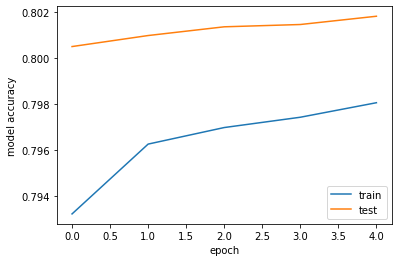

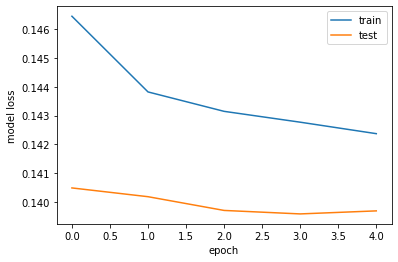

In [11]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# look into training history

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
#plt.savefig('plots_DNN_SUSY/acc3.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()


## Grid Search for Hyperparameter Tuning

In [12]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [59]:
# Wrap the Keras model 
neural_network = KerasClassifier(build_fn=compile_model_lr, # change to compile_model to run grid_1
                                 epochs=1,
                                 batch_size=batch_size,
                                 verbose=1)

# Create hyperparameter space

lr_rates = np.logspace(-4,-1,4)
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adam']
dropout_rates = [0.3,0.4,0.5,0.6]

param_grid = dict(optimizer=optimizers, dropout_rate=dropout_rates)
param_grid_2 = dict(lr_rate=lr_rates)

# Do the grid search
#grid_1 = GridSearchCV(estimator=neural_network, param_grid=param_grid, n_jobs=1, cv=3)
#grid_result_1 = grid_1.fit(X_test, Y_test)

grid_2 = GridSearchCV(estimator=neural_network, param_grid=param_grid_2, n_jobs=1, cv=3)
grid_result_2 = grid_2.fit(X_test, Y_test)





Epoch 1/1
16667/16667 [==============================] - 5s 323us/step
Epoch 1/1
16667/16667 [==============================] - 5s 327us/step
Epoch 1/1
16666/16666 [==============================] - 6s 331us/step
Epoch 1/1
16667/16667 [==============================] - 5s 327us/step
Epoch 1/1
16667/16667 [==============================] - 6s 334us/step
Epoch 1/1
16666/16666 [==============================] - 6s 344us/step
Epoch 1/1
16667/16667 [==============================] - 6s 337us/step
Epoch 1/1
16667/16667 [==============================] - 6s 331us/step
Epoch 1/1
16666/16666 [==============================] - 6s 351us/step
Epoch 1/1
16667/16667 [==============================] - 6s 342us/step
Epoch 1/1
16667/16667 [==============================] - 6s 349us/step
Epoch 1/1
16666/16666 [==============================] - 6s 345us/step
Epoch 1/1
50000/50000 [==============================] - 11s 224us/step - loss: 0.1623 - accuracy: 0.7761


## Visualize the grid search results
### Dropout Rate and Optimizer:

Best: 0.791080 using {'dropout_rate': 0.4, 'optimizer': 'Adagrad'}


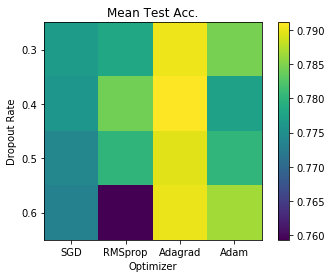

In [53]:
# Summarize results
print('Best: %f using %s' % (grid_result_1.best_score_, grid_result_1.best_params_))

means = grid_result_1.cv_results_['mean_test_score']
stds = grid_result_1.cv_results_['std_test_score']
params = grid_result_1.cv_results_['params']


#for mean, std, param in zip(means, stds, params):
#    print('%f (%f) with: %r' % (mean, std, param))
    
plt.imshow(means.reshape(4,4))
plt.xticks([0., 1., 2., 3.,], optimizers)
plt.xlabel('Optimizer')
plt.yticks([0, 1, 2, 3], dropout_rates)
plt.ylabel('Dropout Rate')
plt.title('Mean Test Acc.')
plt.colorbar()
plt.savefig('plots_DNN_SUSY/gridsearch_droprate_optimizer.png')





### Learning Rate:

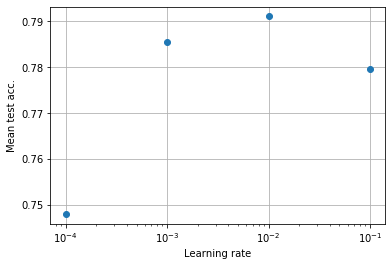

In [60]:
# Compare learning rates

means_lr = grid_result_2.cv_results_['mean_test_score']

plt.semilogx(lr_rates, means_lr, 'o')
plt.xlabel('Learning rate')
plt.ylabel('Mean test acc.')
plt.grid(1)
plt.savefig('plots_DNN_SUSY/gridsearch_learningrate.png')


# Trials & Results

## Grid Search Results

Using initial model, we performed a grid search for an attempt to find the optimal dropout rate and optimizer. Best mean test accuracy was $79.11\%$, with a dropout rate of 0.4 and optimizer Adagrad.

<img src="plots_DNN_SUSY/gridsearch_droprate_optimizer.png"/>

Using the most optimal dropout rate and optimizer found, we also scan learning rate values ranging from $10^{-4}$ to $10^{-1}$. Mean test accuracies for each learning rate can be found in the figure below.

<img src="plots_DNN_SUSY/gridsearch_learningrate.png"/>

From the figure, optimal learning rate is determined to be $10^{-2}$.

